# Eleições presidenciais em João Pessoa - 1º turno

Este notebook apresenta as etapas que segui para analisar a distribuição espacial das eleições presidenciais nos locais de votação em João Pessoa. O motivo é conseguir ver onde cada candidato se saiu melhor de acordo com a região da cidade, uma vez que nos jornais e no site do TSE os resultados agregados só vão até o nível da zona eleitoral.

### Mapa final

Pontos em tons azuis onde Bolsonaro venceu. Pontos em tons vermelhos onde Lula venceu. Quando a cor é mais escura, significa que o candidato obteve mais de 55% dos votos válidos. A cor cinza representa empate.

In [49]:
m

## Procedimento

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

### Boletins de urna

Base dos boletins de urna do TSE para a Paraíba, disponível em https://dadosabertos.tse.jus.br/dataset/resultados-2022-boletim-de-urna.

In [2]:
df = pd.read_csv('bweb_1t_PB.csv', encoding='latin-1', sep=';')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096771 entries, 0 to 1096770
Data columns (total 45 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   DT_GERACAO                   1096771 non-null  object 
 1   HH_GERACAO                   1096771 non-null  object 
 2   ANO_ELEICAO                  1096771 non-null  int64  
 3   CD_TIPO_ELEICAO              1096771 non-null  int64  
 4   NM_TIPO_ELEICAO              1096771 non-null  object 
 5   CD_PLEITO                    1096771 non-null  int64  
 6   DT_PLEITO                    1096771 non-null  object 
 7   NR_TURNO                     1096771 non-null  int64  
 8   CD_ELEICAO                   1096771 non-null  int64  
 9   DS_ELEICAO                   1096771 non-null  object 
 10  SG_UF                        1096771 non-null  object 
 11  CD_MUNICIPIO                 1096771 non-null  int64  
 12  NM_MUNICIPIO                 1096771 non-n

Filtra apenas algumas colunas de interesse, cidade de João Pessoa e eleição presidencial.

In [4]:
df = df[df['NM_MUNICIPIO'] == 'JOÃO PESSOA']
df = df[df['DS_ELEICAO'] == 'Eleição Geral Federal 2022']
df = df[['NR_ZONA', 'NR_SECAO', 'NM_VOTAVEL', 'QT_VOTOS', 'QT_APTOS', 'QT_COMPARECIMENTO', 'QT_ABSTENCOES']]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11273 entries, 0 to 1096606
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   NR_ZONA            11273 non-null  int64 
 1   NR_SECAO           11273 non-null  int64 
 2   NM_VOTAVEL         11273 non-null  object
 3   QT_VOTOS           11273 non-null  int64 
 4   QT_APTOS           11273 non-null  int64 
 5   QT_COMPARECIMENTO  11273 non-null  int64 
 6   QT_ABSTENCOES      11273 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 704.6+ KB


### Locais de votação

Carrega a base de locais de votação do TSE para o Brasil, disponível em https://dadosabertos.tse.jus.br/dataset/eleitorado-atual.

In [6]:
ldf = pd.read_csv('eleitorado_local_votacao_ATUAL.csv', encoding='latin-1', sep=';')

In [7]:
ldf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496512 entries, 0 to 496511
Data columns (total 35 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   DT_GERACAO                    496512 non-null  object 
 1   HH_GERACAO                    496512 non-null  object 
 2   AA_ELEICAO                    496512 non-null  int64  
 3   DT_ELEICAO                    0 non-null       float64
 4   DS_ELEICAO                    496512 non-null  object 
 5   NR_TURNO                      496512 non-null  int64  
 6   SG_UF                         496512 non-null  object 
 7   CD_MUNICIPIO                  496512 non-null  int64  
 8   NM_MUNICIPIO                  496512 non-null  object 
 9   NR_ZONA                       496512 non-null  int64  
 10  NR_SECAO                      496512 non-null  int64  
 11  CD_TIPO_SECAO_AGREGADA        496512 non-null  int64  
 12  DS_TIPO_SECAO_AGREGADA        496512 non-nul

Seleciona na base de locais de votação apenas o município de João Pessoa e alguns campos de interesse.

In [8]:
ldf = ldf[ldf['NM_MUNICIPIO'] == 'JOÃO PESSOA']
ldf = ldf[['NM_BAIRRO', 'NR_LATITUDE', 'NR_LONGITUDE', 'NR_ZONA', 'NR_SECAO', 'NR_LOCAL_VOTACAO', 'NM_LOCAL_VOTACAO']]

In [9]:
ldf.head()

,NM_BAIRRO,NR_LATITUDE,NR_LONGITUDE,NR_ZONA,NR_SECAO,NR_LOCAL_VOTACAO,NM_LOCAL_VOTACAO
76,IPES,-7.105861,-34.858250,1,155,1457,ESC ESTADUAL MONS PEDRO ANISIO BEZERRA
124,FUNCIONARIOS II,-7.182127,-34.881353,77,171,1368,ESCOLA ESTADUAL JOSÉ DO PATROCINIO
197,MANGABEIRA I,-7.169732,-34.841285,70,166,1350,ESCOLA ESTADUAL DE 1 GRAU PEDRO LINS VIEIRA DE...
266,CENTRO,-7.115360,-34.883176,1,6,1040,FAC. CIÊNCIAS MÉDICAS (ANTIGO COLÉGIO PIO XII)
597,MANGABEIRA II,-7.178120,-34.839369,70,443,1929,ESCOLA ESTADUAL DE ENSINO FUNDAMENTAL JOÃO ROB...


### Associando as coordenadas dos locais de votação ao resultado dos boletins de urna

Prepara para a junção entre as bases usando a zona e a seção como chave.

In [10]:
ldf = ldf.set_index(['NR_ZONA', 'NR_SECAO'])
df = df.set_index(['NR_ZONA', 'NR_SECAO'])
df = df.join(ldf, lsuffix='', rsuffix='__LOCAL')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11273 entries, (1, 1) to (77, 402)
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NM_VOTAVEL         11273 non-null  object 
 1   QT_VOTOS           11273 non-null  int64  
 2   QT_APTOS           11273 non-null  int64  
 3   QT_COMPARECIMENTO  11273 non-null  int64  
 4   QT_ABSTENCOES      11273 non-null  int64  
 5   NM_BAIRRO          11270 non-null  object 
 6   NR_LATITUDE        11270 non-null  float64
 7   NR_LONGITUDE       11270 non-null  float64
 8   NR_LOCAL_VOTACAO   11270 non-null  float64
 9   NM_LOCAL_VOTACAO   11270 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 934.9+ KB


In [12]:
df['NM_BAIRRO'].unique()

array(['CENTRO', 'TAMBIÁ', 'TORRE', 'ROGER', 'EXPEDICIONARIOS',
       'CONJUNTO PEDRO GONDIM', 'ESTADOS', 'MANDACARU', 'IPES',
       'TREZE DE MAIO', 'PADRE ZE', 'JARDIM LUNA', 'JOAO AGRIPINO',
       'TAMBAUZINHO', 'CASTELO BRANCO I', 'CASTELO BRANCO', 'MIRAMAR',
       'JAGUARIBE', 'RANGEL', 'CRISTO REDENTOR', 'CRUZ DAS ARMAS',
       'ILHA DO BISPO', 'ERNESTO GEISEL', 'MANGABEIRA I', 'MANGABEIRA II',
       'JOSE AMERICO DE ALMEIDA', 'VALENTINA DE FIGUEIREDO I',
       'MANGABEIRA VI', 'VALENTINA DE FIGUEIREDO II', 'MANGABEIRA VIII',
       'MANGABEIRA IV', 'MANGABEIRA VII', 'VALENTINA FIGUEIREDO', 'BESSA',
       'TAMBAU', 'MANAIRA', 'ALTIPLANO CABO BRANCO', 'CABO BRANCO',
       'BANCARIOS', 'PENHA', 'JARDIM OCEANIA', nan, 'ALTO DO MATEUS',
       'NOVAIS', 'FUNCIONARIOS I', 'JARDIM PLANALTO', 'FUNCIONARIOS II',
       'COSTA E SILVA', 'ERNANI SATIRO', 'JARDIM VENEZA', 'GROTAO',
       'FUNCIONARIOS III', 'INDUSTRIAS', 'CONJUNTO JOSE VIEIRA DINIZ',
       'JOAO PAULO II', 'GRAMA

Salvando o resultado parcial até então.

In [13]:
df.to_csv('eleicao_presidencial_2022_jp_1_turno.csv', sep=';', encoding='utf-8')

### Base de bairros

Carregando a base de bairros de João Pessoa do repositório geodata-jp.

In [14]:
bairros = gpd.read_file('https://raw.githubusercontent.com/paulovitorweb/geodata-jp/main/data/bairros.geojson')

In [15]:
bairros = bairros.drop(columns=['perimetro', 'area', 'hectares', 'densidade'])

In [16]:
bairros.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   cod       64 non-null     object  
 1   nome      64 non-null     object  
 2   geometry  64 non-null     geometry
dtypes: geometry(1), object(2)
memory usage: 1.6+ KB


Converte para um sistema de coordenadas métrico apropriado e plota.

In [17]:
bairros = bairros.to_crs('EPSG:31985')

<AxesSubplot: >

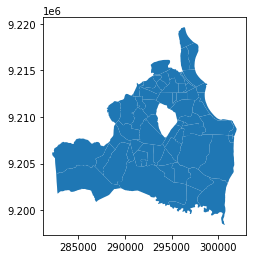

In [18]:
bairros.plot()

### Votos válidos

Para calcular os votos válidos precisamos excluir os votos brancos e nulos.

In [19]:
df = df.query('NM_VOTAVEL not in ("Branco", "Nulo")')
df['NM_VOTAVEL'].unique()

array(['SORAYA THRONICKE', "FELIPE D'AVILA", 'SIMONE TEBET', 'CIRO GOMES',
       'LULA', 'JAIR BOLSONARO', 'VERA', 'SOFIA MANZANO', 'LÉO PÉRICLES',
       'PADRE KELMON', 'CONSTITUINTE EYMAEL'], dtype=object)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8398 entries, (1, 1) to (77, 402)
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NM_VOTAVEL         8398 non-null   object 
 1   QT_VOTOS           8398 non-null   int64  
 2   QT_APTOS           8398 non-null   int64  
 3   QT_COMPARECIMENTO  8398 non-null   int64  
 4   QT_ABSTENCOES      8398 non-null   int64  
 5   NM_BAIRRO          8395 non-null   object 
 6   NR_LATITUDE        8395 non-null   float64
 7   NR_LONGITUDE       8395 non-null   float64
 8   NR_LOCAL_VOTACAO   8395 non-null   float64
 9   NM_LOCAL_VOTACAO   8395 non-null   object 
dtypes: float64(3), int64(4), object(3)
memory usage: 701.9+ KB


### Tratando valores nulos

Existem valores nulos para os locais de votação. Vamos dar uma olhada.

In [21]:
df[df['NM_BAIRRO'].isnull()]

NM_VOTAVEL  QT_VOTOS  QT_APTOS  QT_COMPARECIMENTO  \
NR_ZONA NR_SECAO                                                            
76      389       SORAYA THRONICKE         1        36                 31   
        389                   LULA        29        36                 31   
        389         JAIR BOLSONARO         1        36                 31   

                  QT_ABSTENCOES NM_BAIRRO  NR_LATITUDE  NR_LONGITUDE  \
NR_ZONA NR_SECAO                                                       
76      389                   5       NaN          NaN           NaN   
        389                   5       NaN          NaN           NaN   
        389                   5       NaN          NaN           NaN   

                  NR_LOCAL_VOTACAO NM_LOCAL_VOTACAO  
NR_ZONA NR_SECAO                                     
76      389                    NaN              NaN  
        389                    NaN              NaN  
        389                    NaN              NaN

Fiz uma pesquisa rápida e não encontrei. Vamos seguir como `NÃO IDENTIFICADO`.

In [22]:
df = df.fillna(value={'NM_LOCAL_VOTACAO': 'NÃO IDENTIFICADO'})

### Resultado por local de votação e candidato

Vamos agrupar por local de votação e candidato.

In [23]:
df1 = df.groupby(['NM_LOCAL_VOTACAO', 'NM_VOTAVEL']).agg({'QT_VOTOS': 'sum'})
df1

QT_VOTOS
NM_LOCAL_VOTACAO                     NM_VOTAVEL                
ACADEMIA DE COMERCIO EPITACIO PESSOA CIRO GOMES              83
                                     FELIPE D'AVILA           7
                                     JAIR BOLSONARO         874
                                     LULA                  1010
                                     PADRE KELMON             1
...                                                         ...
VIA MEDICINA COLEGIO E CURSO         LÉO PÉRICLES             1
                                     PADRE KELMON             1
                                     SIMONE TEBET            97
                                     SOFIA MANZANO            3
                                     SORAYA THRONICKE        11

[1733 rows x 1 columns]

Um teste para saber se estou no caminho certo. Segundo o G1 Paraíba (https://g1.globo.com/pb/paraiba/noticia/2022/10/02/eleicoes-em-joao-pessoa-pb-veja-como-foi-a-votacao-no-1o-turno.ghtml):
- Lula (PT): 217.243 votos (47,38%)
- Jair Bolsonaro (PL): 203.971 votos (44,48%)
- Ciro Gomes (PDT): 17.652 votos (3,85%)
- Simone Tebet (MDB): 15.761 votos (3,44%)

In [24]:
votos_por_candidato = df1.groupby(level=1).sum()
votos_por_candidato

,QT_VOTOS
NM_VOTAVEL,
CIRO GOMES,17652
CONSTITUINTE EYMAEL,75
FELIPE D'AVILA,1479
JAIR BOLSONARO,203971
LULA,217243
LÉO PÉRICLES,231
PADRE KELMON,265
SIMONE TEBET,15761
SOFIA MANZANO,179


In [25]:
votos_por_candidato['PERCENTUAL'] = votos_por_candidato['QT_VOTOS'] / votos_por_candidato['QT_VOTOS'].sum()
votos_por_candidato.sort_values('QT_VOTOS', ascending=False)

,QT_VOTOS,PERCENTUAL
NM_VOTAVEL,,
LULA,217243,0.473794
JAIR BOLSONARO,203971,0.444848
CIRO GOMES,17652,0.038498
SIMONE TEBET,15761,0.034374
SORAYA THRONICKE,1555,0.003391
FELIPE D'AVILA,1479,0.003226
PADRE KELMON,265,0.000578
LÉO PÉRICLES,231,0.000504
SOFIA MANZANO,179,0.000390


É isso, confere.

Agora, por local de votação.

In [26]:
df1 = df1.unstack()
df1

QT_VOTOS  \
NM_VOTAVEL                                         CIRO GOMES   
NM_LOCAL_VOTACAO                                                
ACADEMIA DE COMERCIO EPITACIO PESSOA                     83.0   
ASSOCIAÇÃO DOS SERVIDORES DA POLÍCIA FEDERAL - ...       61.0   
CENEC - CENTRO EDUCACIONAL CENECISTA                    149.0   
CENEC - ESCOLA CENECISTA JOÃO REGIS AMORIM              277.0   
CENTRO DA CIDADANIA OTAVIANO FERNANDES COUTINHO          22.0   
...                                                       ...   
NÃO IDENTIFICADO                                          NaN   
SERVICO SOCIAL DA INDUSTRIA - SESI                       11.0   
UFPB CENTRAL DE AULAS                                   436.0   
UNIVERSIDADE ESTADUAL DA PARAÍBA - UEPB                 199.0   
VIA MEDICINA COLEGIO E CURSO                            125.0   

                                                                        \
NM_VOTAVEL                                         CONSTITUINTE EYMAEL   
NM_LOCAL_VOTACAO                                                         
ACADEMIA DE COMERCIO EPITACIO PESSOA                               NaN   
ASSOCIAÇÃO DOS SERVIDORES DA POLÍCIA FEDERAL - ...                 NaN   
CENEC - CENTRO EDUCACIONAL CENECISTA                               NaN   
CENEC - ESCOLA CENECISTA JOÃO REGIS AMORIM                         NaN   
CENTRO DA CIDADANIA OTAVIANO FERNANDES COUTINHO                    NaN   
...                                                                ...   
NÃO IDENTIFICADO                                                   NaN   
SERVICO SOCIAL DA INDUSTRIA - SESI                                 NaN   
UFPB CENTRAL DE AULAS                                              1.0   
UNIVERSIDADE ESTADUAL DA PARAÍBA - UEPB                            NaN   
VIA MEDICINA COLEGIO E CURSO                                       NaN   

                                                                   \
NM_VOTAVEL                                         FELIPE D'AVILA   
NM_LOCAL_VOTACAO                                                    
ACADEMIA DE COMERCIO EPITACIO PESSOA                          7.0   
ASSOCIAÇÃO DOS SERVIDORES DA POLÍCIA FEDERAL - ...            9.0   
CENEC - CENTRO EDUCACIONAL CENECISTA                         18.0   
CENEC - ESCOLA CENECISTA JOÃO REGIS AMORIM                   22.0   
CENTRO DA CIDADANIA OTAVIANO FERNANDES COUTINHO               3.0   
...                                                           ...   
NÃO IDENTIFICADO                                              NaN   
SERVICO SOCIAL DA INDUSTRIA - SESI                            1.0   
UFPB CENTRAL DE AULAS                                        42.0   
UNIVERSIDADE ESTADUAL DA PARAÍBA - UEPB                      14.0   
VIA MEDICINA COLEGIO E CURSO                                 21.0   

                                                                           \
NM_VOTAVEL                                         JAIR BOLSONARO    LULA   
NM_LOCAL_VOTACAO                                                            
ACADEMIA DE COMERCIO EPITACIO PESSOA                        874.0  1010.0   
ASSOCIAÇÃO DOS SERVIDORES DA POLÍCIA FEDERAL - ...          695.0   525.0   
CENEC - CENTRO EDUCACIONAL CENECISTA                       1274.0  1341.0   
CENEC - ESCOLA CENECISTA JOÃO REGIS AMORIM                 2195.0  2003.0   
CENTRO DA CIDADANIA OTAVIANO FERNANDES COUTINHO             374.0   456.0   
...                                                           ...     ...   
NÃO IDENTIFICADO                                              1.0    29.0   
SERVICO SOCIAL DA INDUSTRIA - SESI                          169.0   204.0   
UFPB CENTRAL DE AULAS                                      2852.0  4609.0   
UNIVERSIDADE ESTADUAL DA PARAÍBA - UEPB                    2396.0  2414.0   
VIA MEDICINA COLEGIO E CURSO                               1192.0  1004.0   

                                                           

Preciso obter as coordenadas dos locais.

In [27]:
df2 = df.groupby(['NM_LOCAL_VOTACAO']).agg({'NR_LATITUDE': 'mean', 'NR_LONGITUDE': 'mean'})

In [28]:
df2

,NR_LATITUDE,NR_LONGITUDE
NM_LOCAL_VOTACAO,,
ACADEMIA DE COMERCIO EPITACIO PESSOA,-7.122656,-34.884473
ASSOCIAÇÃO DOS SERVIDORES DA POLÍCIA FEDERAL - PROX PARQUE PB II,-7.080441,-34.836433
CENEC - CENTRO EDUCACIONAL CENECISTA,-7.163410,-34.827805
CENEC - ESCOLA CENECISTA JOÃO REGIS AMORIM,-7.177847,-34.867251
CENTRO DA CIDADANIA OTAVIANO FERNANDES COUTINHO,-7.170910,-34.838149
...,...,...
NÃO IDENTIFICADO,NaN,NaN
SERVICO SOCIAL DA INDUSTRIA - SESI,-7.123403,-34.885977
UFPB CENTRAL DE AULAS,-7.141083,-34.848948


Vamos unir os dois dataframes para chegar a uma base agregada por local de votação com as coordenadas e os votos dos candidatos pivotados para colunas.

In [29]:
result = df2.join(df1, lsuffix='COORD_', rsuffix='QT_VOTOS_')

/tmp/ipykernel_942/2064493752.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  result = df2.join(df1, lsuffix='COORD_', rsuffix='QT_VOTOS_')


In [30]:
result = result.reset_index()
result

,NM_LOCAL_VOTACAO,NR_LATITUDE,NR_LONGITUDE,"(QT_VOTOS, CIRO GOMES)","(QT_VOTOS, CONSTITUINTE EYMAEL)","(QT_VOTOS, FELIPE D'AVILA)","(QT_VOTOS, JAIR BOLSONARO)","(QT_VOTOS, LULA)","(QT_VOTOS, LÉO PÉRICLES)","(QT_VOTOS, PADRE KELMON)","(QT_VOTOS, SIMONE TEBET)","(QT_VOTOS, SOFIA MANZANO)","(QT_VOTOS, SORAYA THRONICKE)","(QT_VOTOS, VERA)"
0,ACADEMIA DE COMERCIO EPITACIO PESSOA,-7.122656,-34.884473,83.0,NaN,7.0,874.0,1010.0,NaN,1.0,50.0,NaN,4.0,NaN
1,ASSOCIAÇÃO DOS SERVIDORES DA POLÍCIA FEDERAL -...,-7.080441,-34.836433,61.0,NaN,9.0,695.0,525.0,2.0,2.0,50.0,NaN,5.0,NaN
2,CENEC - CENTRO EDUCACIONAL CENECISTA,-7.163410,-34.827805,149.0,NaN,18.0,1274.0,1341.0,3.0,2.0,93.0,3.0,5.0,1.0
3,CENEC - ESCOLA CENECISTA JOÃO REGIS AMORIM,-7.177847,-34.867251,277.0,NaN,22.0,2195.0,2003.0,1.0,2.0,147.0,3.0,7.0,3.0
4,CENTRO DA CIDADANIA OTAVIANO FERNANDES COUTINHO,-7.170910,-34.838149,22.0,NaN,3.0,374.0,456.0,NaN,2.0,26.0,2.0,4.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,NÃO IDENTIFICADO,NaN,NaN,NaN,NaN,NaN,1.0,29.0,NaN,NaN,NaN,NaN,1.0,NaN
206,SERVICO SOCIAL DA INDUSTRIA - SESI,-7.123403,-34.885977,11.0,NaN,1.0,169.0,204.0,NaN,NaN,16.0,NaN,1.0,NaN
207,UFPB CENTRAL DE AULAS,-7.141083,-34.848948,436.0,1.0,42.0,2852.0,4609.0,16.0,NaN,261.0,10.0,19.0,1.0
208,UNIVERSIDADE ESTADUAL DA PARAÍBA - UEPB,-7.157929,-34.872929,199.0,NaN,14.0,2396.0,2414.0,2.0,4.0,158.0,4.0,13.0,3.0


Calcular os votos válidos por local de votação.

In [31]:
result['QT_VOTOS_VALIDOS'] = result.iloc[:, 3:].sum(axis=1)
result

,NM_LOCAL_VOTACAO,NR_LATITUDE,NR_LONGITUDE,"(QT_VOTOS, CIRO GOMES)","(QT_VOTOS, CONSTITUINTE EYMAEL)","(QT_VOTOS, FELIPE D'AVILA)","(QT_VOTOS, JAIR BOLSONARO)","(QT_VOTOS, LULA)","(QT_VOTOS, LÉO PÉRICLES)","(QT_VOTOS, PADRE KELMON)","(QT_VOTOS, SIMONE TEBET)","(QT_VOTOS, SOFIA MANZANO)","(QT_VOTOS, SORAYA THRONICKE)","(QT_VOTOS, VERA)",QT_VOTOS_VALIDOS
0,ACADEMIA DE COMERCIO EPITACIO PESSOA,-7.122656,-34.884473,83.0,NaN,7.0,874.0,1010.0,NaN,1.0,50.0,NaN,4.0,NaN,2029.0
1,ASSOCIAÇÃO DOS SERVIDORES DA POLÍCIA FEDERAL -...,-7.080441,-34.836433,61.0,NaN,9.0,695.0,525.0,2.0,2.0,50.0,NaN,5.0,NaN,1349.0
2,CENEC - CENTRO EDUCACIONAL CENECISTA,-7.163410,-34.827805,149.0,NaN,18.0,1274.0,1341.0,3.0,2.0,93.0,3.0,5.0,1.0,2889.0
3,CENEC - ESCOLA CENECISTA JOÃO REGIS AMORIM,-7.177847,-34.867251,277.0,NaN,22.0,2195.0,2003.0,1.0,2.0,147.0,3.0,7.0,3.0,4660.0
4,CENTRO DA CIDADANIA OTAVIANO FERNANDES COUTINHO,-7.170910,-34.838149,22.0,NaN,3.0,374.0,456.0,NaN,2.0,26.0,2.0,4.0,NaN,889.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,NÃO IDENTIFICADO,NaN,NaN,NaN,NaN,NaN,1.0,29.0,NaN,NaN,NaN,NaN,1.0,NaN,31.0
206,SERVICO SOCIAL DA INDUSTRIA - SESI,-7.123403,-34.885977,11.0,NaN,1.0,169.0,204.0,NaN,NaN,16.0,NaN,1.0,NaN,402.0
207,UFPB CENTRAL DE AULAS,-7.141083,-34.848948,436.0,1.0,42.0,2852.0,4609.0,16.0,NaN,261.0,10.0,19.0,1.0,8247.0
208,UNIVERSIDADE ESTADUAL DA PARAÍBA - UEPB,-7.157929,-34.872929,199.0,NaN,14.0,2396.0,2414.0,2.0,4.0,158.0,4.0,13.0,3.0,5207.0


Há 11 candidatos, mas 2 se destacam. Para facilitar a análise, vamos agrupar.

In [32]:
result['LULA'] = result[('QT_VOTOS', 'LULA')]
result['BOLSONARO'] = result[('QT_VOTOS', 'JAIR BOLSONARO')]
result['OUTROS'] = result['QT_VOTOS_VALIDOS'] - result['LULA'] - result['BOLSONARO']

In [33]:
result = result[['NM_LOCAL_VOTACAO', 'NR_LATITUDE', 'NR_LONGITUDE', 'LULA', 'BOLSONARO', 'OUTROS', 'QT_VOTOS_VALIDOS']]

In [34]:
result

,NM_LOCAL_VOTACAO,NR_LATITUDE,NR_LONGITUDE,LULA,BOLSONARO,OUTROS,QT_VOTOS_VALIDOS
0,ACADEMIA DE COMERCIO EPITACIO PESSOA,-7.122656,-34.884473,1010.0,874.0,145.0,2029.0
1,ASSOCIAÇÃO DOS SERVIDORES DA POLÍCIA FEDERAL -...,-7.080441,-34.836433,525.0,695.0,129.0,1349.0
2,CENEC - CENTRO EDUCACIONAL CENECISTA,-7.163410,-34.827805,1341.0,1274.0,274.0,2889.0
3,CENEC - ESCOLA CENECISTA JOÃO REGIS AMORIM,-7.177847,-34.867251,2003.0,2195.0,462.0,4660.0
4,CENTRO DA CIDADANIA OTAVIANO FERNANDES COUTINHO,-7.170910,-34.838149,456.0,374.0,59.0,889.0
...,...,...,...,...,...,...,...
205,NÃO IDENTIFICADO,NaN,NaN,29.0,1.0,1.0,31.0
206,SERVICO SOCIAL DA INDUSTRIA - SESI,-7.123403,-34.885977,204.0,169.0,29.0,402.0
207,UFPB CENTRAL DE AULAS,-7.141083,-34.848948,4609.0,2852.0,786.0,8247.0
208,UNIVERSIDADE ESTADUAL DA PARAÍBA - UEPB,-7.157929,-34.872929,2414.0,2396.0,397.0,5207.0


Certo, temos um resultado. Mas não faz sentido os votos não estarem como inteiros.

In [35]:
result = result.astype({'LULA': 'int', 'BOLSONARO': 'int', 'OUTROS': 'int', 'QT_VOTOS_VALIDOS': 'int'})
result

,NM_LOCAL_VOTACAO,NR_LATITUDE,NR_LONGITUDE,LULA,BOLSONARO,OUTROS,QT_VOTOS_VALIDOS
0,ACADEMIA DE COMERCIO EPITACIO PESSOA,-7.122656,-34.884473,1010,874,145,2029
1,ASSOCIAÇÃO DOS SERVIDORES DA POLÍCIA FEDERAL -...,-7.080441,-34.836433,525,695,129,1349
2,CENEC - CENTRO EDUCACIONAL CENECISTA,-7.163410,-34.827805,1341,1274,274,2889
3,CENEC - ESCOLA CENECISTA JOÃO REGIS AMORIM,-7.177847,-34.867251,2003,2195,462,4660
4,CENTRO DA CIDADANIA OTAVIANO FERNANDES COUTINHO,-7.170910,-34.838149,456,374,59,889
...,...,...,...,...,...,...,...
205,NÃO IDENTIFICADO,NaN,NaN,29,1,1,31
206,SERVICO SOCIAL DA INDUSTRIA - SESI,-7.123403,-34.885977,204,169,29,402
207,UFPB CENTRAL DE AULAS,-7.141083,-34.848948,4609,2852,786,8247
208,UNIVERSIDADE ESTADUAL DA PARAÍBA - UEPB,-7.157929,-34.872929,2414,2396,397,5207


Melhor.

Vamos salvar o resultado parcial em um arquivo que pode ser útil fora daqui.

In [36]:
result.to_csv('eleicao_presidencial_2022_jp_1_turno_por_local_de_votacao.csv', sep=';', encoding='utf-8')

## Mapas

Vamos tentar obter alguns mapas para analisar.

<AxesSubplot: >

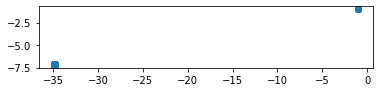

In [37]:
gdf = gpd.GeoDataFrame(
    result, geometry=gpd.points_from_xy(result.NR_LONGITUDE, result.NR_LATITUDE), crs='EPSG:4326')
gdf.plot()

Oxe. Parece que temos uma ou mais coordenadas erradas.

In [38]:
result.sort_values('NR_LONGITUDE')

,NM_LOCAL_VOTACAO,NR_LATITUDE,NR_LONGITUDE,LULA,BOLSONARO,OUTROS,QT_VOTOS_VALIDOS,geometry
151,ESCOLA MUNICIPAL DE ENSINO FUNDAMENTAL PROF. A...,-7.173992,-34.929570,1845,1665,222,3732,POINT (-34.92957 -7.17399)
66,ESC. MUN. ANAYDE BEIRIZ (PROVISÓRIO)- ENTRADA ...,-7.175178,-34.919875,1602,1467,194,3263,POINT (-34.91987 -7.17518)
102,ESCOLA ESTADUAL DE ENS. FUND. D. JOSE MARIA PIRES,-7.183092,-34.919803,560,524,82,1166,POINT (-34.91980 -7.18309)
112,ESCOLA ESTADUAL DE ENSINO FUNDAMENTAL SANTOS D...,-7.176929,-34.917247,481,549,84,1114,POINT (-34.91725 -7.17693)
68,ESC. MUN. LYNALDO C. DE ALBUQUERQUE - AO LADO ...,-7.178657,-34.914477,1156,971,154,2281,POINT (-34.91448 -7.17866)
...,...,...,...,...,...,...,...,...
26,COLÉGIO IPI,-1.000000,-1.000000,369,391,70,830,POINT (-1.00000 -1.00000)
172,ESCOLA MUNICIPAL PROF. AFONSO PEREIRA DA SILVA,-1.000000,-1.000000,826,554,97,1477,POINT (-1.00000 -1.00000)
7,CENTRO DE FORMAÇÃO DE EDUCADORES DE JOÃO PESSOA,-1.000000,-1.000000,754,665,89,1508,POINT (-1.00000 -1.00000)
183,ESCOLA SÃO JOSÉ,-1.000000,-1.000000,674,670,125,1469,POINT (-1.00000 -1.00000)


Alguns locais não têm coordenadas válidas. Vamos ver quais são e corrigir isso.

### Inserindo coordenadas faltantes

In [39]:
result[result['NR_LATITUDE'] > -2]

,NM_LOCAL_VOTACAO,NR_LATITUDE,NR_LONGITUDE,LULA,BOLSONARO,OUTROS,QT_VOTOS_VALIDOS,geometry
7,CENTRO DE FORMAÇÃO DE EDUCADORES DE JOÃO PESSOA,-1.0,-1.0,754,665,89,1508,POINT (-1.00000 -1.00000)
26,COLÉGIO IPI,-1.0,-1.0,369,391,70,830,POINT (-1.00000 -1.00000)
61,ESC. ESTADUAL PADRE IBIAPINA,-1.0,-1.0,453,404,83,940,POINT (-1.00000 -1.00000)
172,ESCOLA MUNICIPAL PROF. AFONSO PEREIRA DA SILVA,-1.0,-1.0,826,554,97,1477,POINT (-1.00000 -1.00000)
183,ESCOLA SÃO JOSÉ,-1.0,-1.0,674,670,125,1469,POINT (-1.00000 -1.00000)
197,INSTITUTO EDUCACIONAL NOSSA SENHORA DA CONCEIÇ...,-1.0,-1.0,156,146,36,338,POINT (-1.00000 -1.00000)


Pesquisei no Google Maps e cheguei a essas coordenadas.

In [40]:
coords = {
    'CENTRO DE FORMAÇÃO DE EDUCADORES DE JOÃO PESSOA': (-7.172783, -34.836622),
    'COLÉGIO IPI': (-7.207003, -34.842519),
    'ESC. ESTADUAL PADRE IBIAPINA': (-7.099499, -34.865680), # não é Mandacaru, e sim Alto do Céu
    'ESCOLA MUNICIPAL PROF. AFONSO PEREIRA DA SILVA': (-7.177313, -34.818340),
    'ESCOLA SÃO JOSÉ': (-7.121386, -34.869185),
    'INSTITUTO EDUCACIONAL NOSSA SENHORA DA CONCEIÇÃO - IENSC': (-7.203284, -34.846888),
}

for index in result[result['NR_LATITUDE'] == -1.0].index:
    result.loc[index, 'NR_LATITUDE'] = coords[result.loc[index, 'NM_LOCAL_VOTACAO']][0]
    result.loc[index, 'NR_LONGITUDE'] = coords[result.loc[index, 'NM_LOCAL_VOTACAO']][1]

In [41]:
gdf = gpd.GeoDataFrame(
    result, geometry=gpd.points_from_xy(result.NR_LONGITUDE, result.NR_LATITUDE), crs='EPSG:4326')

In [42]:
gdf = gdf.to_crs('EPSG:31985')

Vamos plotar e ver se deu certo.

<AxesSubplot: >

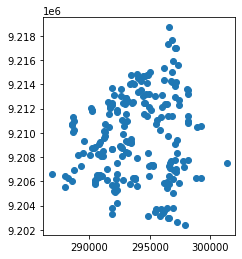

In [43]:
gdf.plot()

Conheço essa cidade rs. Vamos ver com a base de bairros que carregamos anteriormente.

<AxesSubplot: >

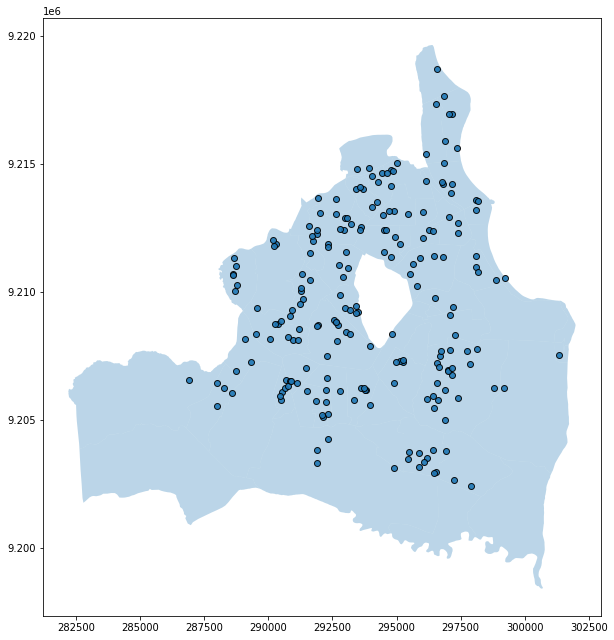

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(11,11))
bairros.plot(ax=ax, alpha=0.3, zorder=1)
gdf.plot(ax=ax, alpha=0.9, edgecolor='k', zorder=2)

### Mapa dos locais de votação segundo candidato com melhor desempenho

A ideia é ver onde cada candidato se saiu melhor.

In [45]:
import folium

In [46]:
gdf = gdf[gdf['NM_LOCAL_VOTACAO'] != 'NÃO IDENTIFICADO']
gdf

,NM_LOCAL_VOTACAO,NR_LATITUDE,NR_LONGITUDE,LULA,BOLSONARO,OUTROS,QT_VOTOS_VALIDOS,geometry
0,ACADEMIA DE COMERCIO EPITACIO PESSOA,-7.122656,-34.884473,1010,874,145,2029,POINT (291876.187 9212267.351)
1,ASSOCIAÇÃO DOS SERVIDORES DA POLÍCIA FEDERAL -...,-7.080441,-34.836433,525,695,129,1349,POINT (297165.064 9216957.874)
2,CENEC - CENTRO EDUCACIONAL CENECISTA,-7.163410,-34.827805,1341,1274,274,2889,POINT (298154.696 9207785.093)
3,CENEC - ESCOLA CENECISTA JOÃO REGIS AMORIM,-7.177847,-34.867251,2003,2195,462,4660,POINT (293803.677 9206170.805)
4,CENTRO DA CIDADANIA OTAVIANO FERNANDES COUTINHO,-7.170910,-34.838149,456,374,59,889,POINT (297015.349 9206951.020)
...,...,...,...,...,...,...,...,...
204,MOTIVA AMBIENTAL,-7.114607,-34.828009,2216,2578,576,5370,POINT (298110.808 9213182.752)
206,SERVICO SOCIAL DA INDUSTRIA - SESI,-7.123403,-34.885977,204,169,29,402,POINT (291710.415 9212184.152)
207,UFPB CENTRAL DE AULAS,-7.141083,-34.848948,4609,2852,786,8247,POINT (295809.151 9210245.133)
208,UNIVERSIDADE ESTADUAL DA PARAÍBA - UEPB,-7.157929,-34.872929,2414,2396,397,5207,POINT (293167.475 9208371.215)


In [47]:
m = folium.Map(
    location=[-7.146122, -34.852709], 
    zoom_start=12, 
    tiles='cartodbpositron', 
    control_scale=True
)

def get_color(label):
    color = {
        "LULA_GANHOU": '#FF0000',
        "LULA_GANHOU_MAIS_55": '#8B0000',
        "BOLSONARO_GANHOU": '#0000FF',
        "BOLSONARO_GANHOU_MAIS_55": '#00008B',
        "OUTRO_GANHOU": "#cfffca",
        "OUTRO_GANHOU_MAIS_55": '#5dc460',
        "EMPATE": '#303030'
    }
    return color[label]

def get_label(index):
    label = 'ERRO'
    lula, bolsonaro, outros, total = gdf.loc[index, 'LULA'], gdf.loc[index, 'BOLSONARO'], \
        gdf.loc[index, 'OUTROS'], gdf.loc[index, 'QT_VOTOS_VALIDOS']
    sorted_values = sorted([lula, bolsonaro, outros], reverse=True)
    if sorted_values[0] == sorted_values[1]:
        label = 'EMPATE'
    elif lula == sorted_values[0]:
        label = 'LULA_GANHOU'
        if lula / total > 0.55:
            label = 'LULA_GANHOU_MAIS_55'
    elif bolsonaro == sorted_values[0]:
        label = 'BOLSONARO_GANHOU'
        if bolsonaro / total > 0.55:
            label = 'BOLSONARO_GANHOU_MAIS_55'
    elif outros == sorted_values[0]:
        label = 'OUTRO_GANHOU'
        if outros / total > 0.55:
            label = 'OUTRO_GANHOU_MAIS_55'
    return label

def get_popup(index):
    lula, bolsonaro, outros, total, nome_local = gdf.loc[index, 'LULA'], gdf.loc[index, 'BOLSONARO'], \
        gdf.loc[index, 'OUTROS'], gdf.loc[index, 'QT_VOTOS_VALIDOS'], gdf.loc[index, 'NM_LOCAL_VOTACAO']
    def percent(value):
        return "{0:.1%}".format(value/total)
    html_votos = f"""
        <p><b>Lula</b>: {lula} ({percent(lula)})</p>
        <p><b>Bolsonaro</b>: {bolsonaro} ({percent(bolsonaro)})</p>
        <p><b>Outros</b>: {outros} ({percent(outros)})</p>
        <p><b>Total</b>: {total}</p>
    """
    return f"""
        <div style='width:300px'>
            <p><b>{nome_local} - 1º TURNO</b></p>
            {html_votos}
        </div>
    """

for index in gdf.index:
    label = get_label(index)
    coords_location = gdf.loc[index, 'NR_LATITUDE'], gdf.loc[index, 'NR_LONGITUDE']
    folium.CircleMarker(
        coords_location, 
        radius=7, 
        color='#FFF',
        fill_color=get_color(label),
        fill_opacity=1,
        popup=get_popup(index),
        weight=2
    ).add_to(m)

### Mapa final

Pontos em tons azuis onde Bolsonaro venceu. Pontos em tons vermelhos onde Lula venceu. Quando a cor é mais escura, significa que o candidato obteve mais de 55% dos votos válidos. A cor cinza representa empate.

In [49]:
m